In [13]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
import argparse
import cv2
import numpy as np

In [14]:
# set the computation device -------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
# Load model checkpoint
checkpoint = 'checkpoints/checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint, map_location = device)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()


Loaded checkpoint from epoch 232.



SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [16]:
# Transforms -----------------------------
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [17]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """
    # Transform
    image = normalize(to_tensor(resize(original_image)))
    # Move to default device
    image = image.to(device)
    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))
    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)
    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')
    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims
    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]
    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image
    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("arial.ttf", 22)
    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue
        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])
        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw
    return annotated_image

In [18]:
!ls

arial.ttf		 img	      VOC2007
checkpoints		 input	      VOC2012
create_data_lists.py	 LICENSE      VOCdevkit
datasets.py		 model.py     VOCdevkit (2)
detect_image.py		 outputs      VOCdevkit (3)
detect.py		 __pycache__  VOCtest_06-Nov-2007.tar
detect_vid.py		 README.md    VOCtrainval_06-Nov-2007.tar
eval.py			 train.py     VOCtrainval_11-May-2012.tar
fede_detect_image.ipynb  utils.py


In [19]:
!ls input

gravante.jpeg  image2.jpg  jesus.jpg	odin.jpeg	 video1.mp4
image1.jpg     image3.jpg  laport.jpeg	PlantChudi.jpeg  video2.mp4


In [27]:
img_pth = './input/image2.jpg'

In [28]:
img = Image.open(img_pth)

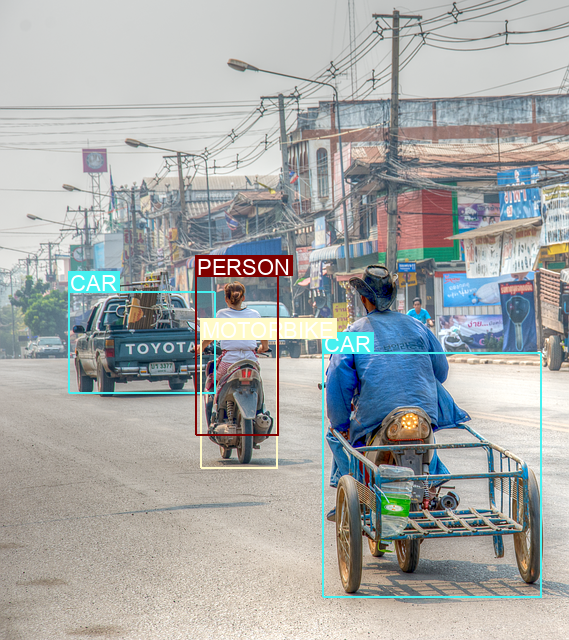

In [29]:
detect(img, .5, .6, top_k = 5)

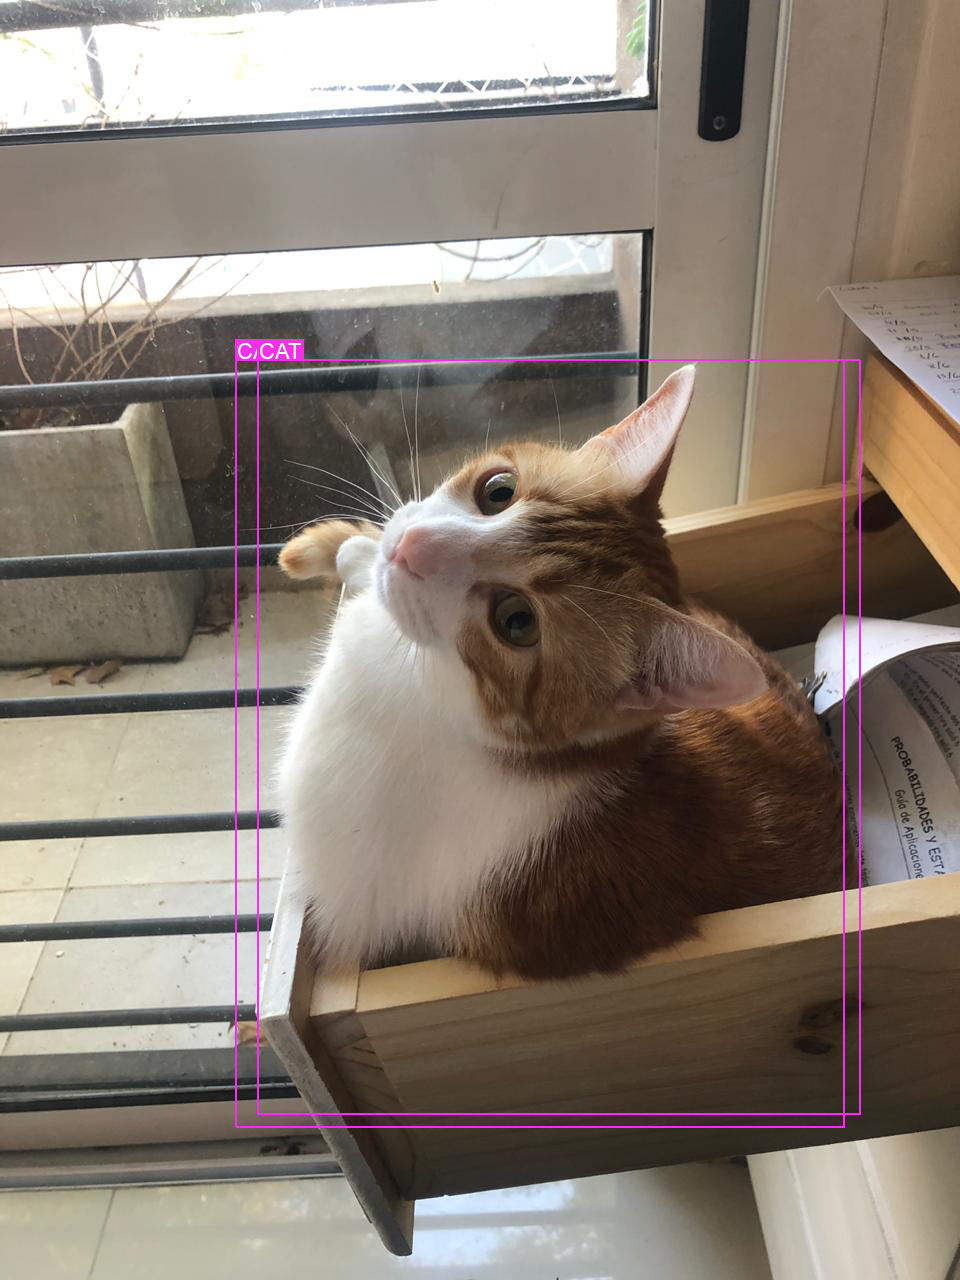

In [23]:
detect(img, .2, .6, top_k = 5)